# Text based competition relationship among companies

### Overview

Author: Chenyu Shen (Rainy)
Date: August 16, 2020

This notebook explores the possibilities of representing the competition relationship among companies by analyzing the text similarities among companies' product description written in 10-K statements. The goal is to generate a dynammic competition relationship that reflects what the company describes itself, instead of following the static given industry codes like NAICS. 

Please refer to the documentation of this Jupyter notebook: "Documentation - Text Similarity" for more details.

In [1]:
# Set up data mining library of Edgar
import edgar
from edgar import Company
from bs4 import BeautifulSoup
from edgar import Company, TXTML, XBRL, XBRLElement

# Set up python standard analytics frameworks
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import re
import unicodedata
from collections import Counter
from collections import defaultdict

# NLP framworks
from gensim import corpora
import gensim

# Visualization
import matplotlib
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Store/read data to pickle file (cache file)
import pickle


## Preprocess Compustats data 

In [7]:
# import data
df = pd.read_csv("data_output/df_na_annual_15-19.csv")

In [8]:
# Data Inspection
print("number of companies in this dataset {}".format(len(df['cik'].unique())))
df.head()

number of companies in this dataset 8437


,gvkey,cik,cusip,conm,fyear,naicsh,Net Income(Loss),Assets - Total,Stockholders' Equity - Total,ROA,ROE
0,1004,1750,000361105,AAR CORP,2014.0,423860.0,10.2,1515.0,845.1,0.006733,0.012070
1,1004,1750,000361105,AAR CORP,2015.0,423860.0,47.7,1442.1,865.8,0.033077,0.055094
2,1004,1750,000361105,AAR CORP,2016.0,423860.0,56.5,1504.1,914.2,0.037564,0.061803
3,1004,1750,000361105,AAR CORP,2017.0,423860.0,15.6,1524.7,936.3,0.010232,0.016661
4,1004,1750,000361105,AAR CORP,2018.0,423860.0,7.5,1517.2,905.9,0.004943,0.008279


In [9]:
# Assign naics industry code super class to each row. 
naics = df['naicsh'].to_list()
naics = [str(e)[:2] for e in naics]
df['naics_super'] = naics

In [10]:
# Filter out companies that does not contain records of 2019 fiscal year
df = df[(df.fyear == 2019)]
len(df),len(df.cik.unique())

(5519, 5519)

In [11]:
# Check some individual companies

# check by company name
df[df.conm.str.contains("ALPHABET")]

,gvkey,cik,cusip,conm,fyear,naicsh,Net Income(Loss),Assets - Total,Stockholders' Equity - Total,ROA,ROE,naics_super
30029,160329,1652044,02079K305,ALPHABET INC,2019.0,518210.0,34343.0,275909.0,201442.0,0.124472,0.170486,51


In [12]:
# Check number of companies in each industry code
group = df.groupby('naics_super')
len(group),group.size()

(23, naics_super
 11      11
 21     316
 22     211
 23      62
 31     135
 32    1001
 33     974
 42     128
 44      95
 45      66
 48     151
 49       3
 51     575
 52     944
 53     302
 54     147
 56      84
 61      35
 62      68
 71      30
 72      81
 81       9
 99      91
 dtype: int64)

In [13]:
# Prepare a company code and name look up dictionary: company_codes {cik:name}

# list of cik
cik_lst = df['cik'].to_list()
cik_lst = [str(int(w)) for w in cik_lst]
# list of company names
conm_lst = df['conm'].to_list()
# populate dictionary
company_codes = dict(zip(cik_lst,conm_lst))

In [14]:
# Industry NAICS code and category name lookup dict industry_dct {naics:category}
# reference: https://www.naics.com/search/#naics

industry_dct = {
    '11' : 'Agriculture, Forestry, Fishing and Hunting',
    '21' : 'Mining',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale Trade',
    '44' : 'Retail Trade',
    '45' : 'Retail Trade',
    '48' : 'Transportation and Warehousing',
    '49' : 'Transportation and Warehousing',
    '51' : 'Information',
    '52' : 'Finance and Insurance',
    '53' : 'Real Estate Rental and Leasing',
    '54' : 'Professional, Scientific, and Technical Services',
    '55' : 'Management of Companies and Enterprises',
    '56' : 'Administrative and Support and Waste Management and Remediation Services',
    '61' : 'Educational Services',
    '62' : 'Health Care and Social Assistance',
    '71' : 'Arts, Entertainment, and Recreation',
    '72' : 'Accommodation and Food Services',
    '81' : 'Other Services (except Public Administration)',
    '92' : 'Public Administration'
}


In [15]:
len(company_codes), len(industry_dct)

(5519, 24)

In [17]:
# select companies in specific industry
select_code = '51'
df_industry = df[(df['naics_super'].str.startswith(select_code))]
print("number of companies in {} (NAICS code starts with {}): {}"
      .format(industry_dct[select_code],select_code,len(df_industry.cik.unique())))


number of companies in Information (NAICS code starts with 51): 575


In [18]:
# Inspect selected industry data
# sort industry companies by size (Total Assets)
df_industry.groupby('conm').mean().sort_values(by = 'Assets - Total', ascending = False).head()

,gvkey,cik,fyear,naicsh,Net Income(Loss),Assets - Total,Stockholders' Equity - Total,ROA,ROE
conm,,,,,,,,,
AT&T INC,9899,732717,2019.0,517312.0,13903.0,551669.0,184221.0,0.025202,0.075469
VERIZON COMMUNICATIONS INC,2136,732712,2019.0,517312.0,19265.0,291727.0,61395.0,0.066038,0.313788
MICROSOFT CORP,12141,789019,2019.0,511210.0,39240.0,286556.0,102330.0,0.136937,0.383465
ALPHABET INC,160329,1652044,2019.0,518210.0,34343.0,275909.0,201442.0,0.124472,0.170486
COMCAST CORP,3226,1166691,2019.0,515210.0,13057.0,263414.0,82726.0,0.049568,0.157834


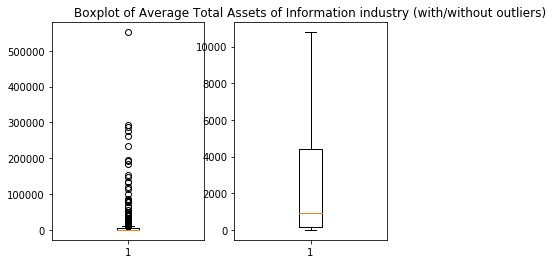

In [20]:
# Visualization of company sizes of selected industry
plt.subplot(1,2,1)
plt.boxplot(x = df_industry.groupby('conm').mean()['Assets - Total'])

plt.subplot(1,2,2)
plt.boxplot(x = df_industry.groupby('conm').mean()['Assets - Total'], showfliers = False)

plt.title("Boxplot of Average Total Assets of {} industry (with/without outliers)".format(industry_dct[select_code]))
plt.show()

## Text Mining from Edgar 

### Load Prerecorded data

In [4]:
def toPickle(data,filepath):
    """
    Store data to a cache file prevent from having to run text minnig every time.
    """
    directory = 'tmp_file/'
    pickle.dump(data, open(directory + filepath, "wb" ))

In [5]:
def fromPickle(filepath):
    """
    Read data to a cache file prevent from having to run text minnig every time.
    """
    directory = 'tmp_file/'
    company_docs = pickle.load(open(directory + filepath, "rb" ) )
    return company_docs

### Text Mining
Text minnig of 600 copies of 10k takes 15min-30min on my computer. Average one company takes 1~2 seconds of wall time.

In [98]:
# select companies in specific industry
select_code = '72'
df_industry = df[(df['naics_super'].str.startswith(select_code))]
print("Number of companies in {} (NAICS code starts with {}): {}"
      .format(industry_dct[select_code],select_code,len(df_industry.cik.unique())))
print("Estimated time to complete text mining for this industry (one 10-K document for each company) is {} minutes"
      .format(round((1.5*len(df_industry)/60),2)))

Number of companies in Accommodation and Food Services (NAICS code starts with 72): 81
Estimated time to complete text mining for this industry (one 10-K document for each company) is 2.02 minutes


In [99]:
# Prepare a dictionary to store data result: company_docs {cik : [document]}

# list of cik
cik_lst = df_industry['cik'].to_list()
cik_lst = [str(int(w)) for w in cik_lst]
# list of company names
conm_lst = df_industry['conm'].to_list()
# company name and cik dictionary of selected industry industry_code {cik:name}
industry_code = dict(zip(cik_lst,conm_lst))

company_docs = {k : [] for k in cik_lst}
len(company_docs)

81

In [101]:
%%time
# Text Mining
from edgar import Company, XBRL, XBRLElement

for cik, conm in industry_code.items():
    company = Company(conm, cik)
    results = company.get_document_type_from_10K("10-K", no_of_documents = 1)

    for d in results:
        company_docs[cik].append(str(d.text_content()))

CPU times: user 21.9 s, sys: 1.03 s, total: 22.9 s
Wall time: 1min 28s


In [102]:
# Store text mining result to pickle file
filepath = 'industry_2019_10k_{}.p'.format(select_code)
filepath
toPickle(company_docs,filepath)

## Load Data from Cache File 
This is to expediate the data mining process by loading chache result of company_docs by industries.

In [23]:
# check existing chache file in the directory
import os
filenames = []
for file in os.listdir('tmp_file'):
    print(file)

my_model.p
industry_2019_10k_42.p
industry_2019_10k_23.p
industry_2019_10k_48.p
company_topic_dct_bus_52.p
industry_2019_10k_52.p
industry_2019_10k_56.p
industry_2019_10k_51.p
industry_2019_10k_11.p
industry_2019_10k_44.p
industry_2019_10k_61.p
industry_2019_10k_21.p
company_topic_dct_52.p
industry_2019_10k_31.p
industry_2019_10k_54.p
industry_2019_10k_71.p
industry_2019_10k_62.p
.ipynb_checkpoints
industry_2019_10k_22.p
industry_2019_10k_32.p
industry_2019_10k_53.p
industry_2019_10k_72.p


In [28]:
import os # read filename in directory

# 10-K documents from all companies in each industry. all_industry: Dictionary {naics : {cik:[document]}}
all_industry = {}
for filepath in os.listdir('tmp_file'):
    # find corresponding datafile
    if filepath.startswith('industry_2019_10k_'):
        naics = filepath[-4:-2]
        all_industry[naics] = fromPickle(filepath)

In [29]:
# Check result
len(all_industry) # number of industries

18

In [30]:
# Check result
all_industry.keys() # industry codes

dict_keys(['42', '23', '48', '52', '56', '51', '11', '44', '61', '21', '31', '54', '71', '62', '22', '32', '53', '72'])

In [31]:
all_industry['42'].keys() # companies codes in specific industry

dict_keys(['2178', '821026', '7536', '8858', '109563', '721371', '18172', '21828', '31667', '352825', '40987', '277135', '205402', '46250', '1093082', '1481582', '52795', '703604', '927653', '65312', '71829', '75252', '76282', '90045', '96021', '99302', '102037', '105016', '106532', '790703', '789460', '1552797', '1552275', '815556', '1180262', '839087', '1538849', '1328581', '1573097', '1665918', '1581990', '1577916', '1474167', '1591588', '1599489', '1599617', '747540', '1494319', '1600438', '874292', '1107713', '885307', '887733', '891024', '1650729', '1604627', '1654795', '1651958', '1402057', '877422', '1618673', '911649', '912603', '1688941', '917470', '900075', '918965', '861884', '927355', '932696', '1140859', '942126', '1641398', '319016', '835662', '1680873', '1740332', '1737372', '1713210', '1626745', '1743745', '1725255', '912061', '945114', '945983', '928465', '945841', '1000228', '1003078', '1005516', '1020859', '1022408', '1022321', '1020710', '1026662', '1030997', '1714

In [40]:
all_industry['42']['2178'][0][20000:21000] # check specific company, sliced text

'l-known seasoned issuer, as defined in Rule 405 of the Securities Act.   Yes o   No þIndicate by check mark if the registrant is not required to file reports pursuant to Section 13 or Section 15(d) of the Act.   Yes o   No þIndicate by check mark whether the registrant (1) has filed all reports required to be filed by Section 13 or 15(d) of the Securities Exchange Act of 1934 during the preceding 12 months (or for such shorter period that the registrant was required to file such reports), and (2) has been subject to such filing requirements for the past 90 days.   Yes þ   No oIndicate by check mark whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T during the preceding 12 months (or for such shorter period that the registrant was required to submit such files).   Yes þ   No oIndicate by check mark whether the registrant is a large accelerated filer, an accelerated filer, a non-accelerated file

### Text Preprocessing 

In [41]:
# remove company with no 10-k file or contains amendment
all_industry = {naics:{k:v for k,v in all_industry[naics].items() if len(v) == 1} for naics in all_industry.keys()}

In [44]:
len(all_industry['52']) # check result

730

In [45]:
%%time

# Text Preprocessing

# all_industry_sample: dictionary {naics : {cik : [item1_business_10k]}}
all_industry_sample = {}

for naics in all_industry:
    company_docs = all_industry[naics]
    sample_lst = {k:[] for k in company_docs.keys()}
    for k,v in company_docs.items():
        text = v[0]
        # normalize text
        text = text.lower()
        # remove title and bars
        index = text.find('the fiscal year ended')
        if index >= 0:
            text = text[index:]
        # remove unicode data
        text = unicodedata.normalize("NFKD", text)
        # remove tab, linefeed
        text = re.sub('\\n|\\t',' ', text)
        # remove duplicate whitespaces
        text = re.sub('\s+',' ',text)
        # Extract Part 1 item 1 - "Business" from the text
        business_text = re.findall("item 1\.(.*)item 1a\.", text)
        if len(business_text) > 0:
            business_text = business_text[0]

        sample_lst[k].append(business_text)
        
    all_industry_sample[naics] = sample_lst

CPU times: user 1min 38s, sys: 8.46 s, total: 1min 47s
Wall time: 1min 47s


In [47]:
# check result for those companies that are not included in the list after preprocessing
all_industry_sample_dct = {}
for naics, sample_lst in all_industry_sample.items():
    code_lst = []
    for k,doc in sample_lst.items():
        if type(doc[0]) != str:
            code_lst.append(k)

    # Remove companies whose text conetents are empty
    sample_dct = dict([(key, val) for key, val in 
               sample_lst.items() if key not in code_lst]) 
    
    all_industry_sample_dct[naics] = sample_dct

In [49]:
# store to a chache file
# toPickle(all_industry_sample_dct,'all_industry_sample_dct.p')

In [7]:
all_industry_sample_dct = fromPickle('all_industry_sample_dct.p')

## Text Analysis 

### Prepare data

In [188]:
len(sample_dct)

668

In [14]:
# import random  
from random import sample 

# Select a random sampling of industries from the industry pool
my_industry_codes = sample(list(all_industry_sample_dct.keys()),3)
my_industry_codes

['71', '51', '62']

In [15]:
my_doc = []
for naics in my_industry_codes:
    for cik, document in all_industry_sample_dct[naics].items():
        my_doc.append(document)

In [16]:
# Code my sample to must include Finance and Insurance industry (naics = 52)
my_doc = my_doc + list(all_industry_sample_dct['52'].values())


In [18]:
# Check the result in this random sample
len(my_doc)

1093

###  Train a custom word2vec model

In [19]:
# Prepare a Gensim corpus for our word2vec model
from gensim import utils

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        for doc in my_doc:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(doc[0])
            

In [20]:
%%time
import gensim.models

# instantiate a gensim text corpus
sentences = MyCorpus()

# Construct a word2vec model using selected corpus; or we can load a pre-trained model using the code in the cell below
model = gensim.models.Word2Vec(sentences=sentences)
# toPickle(model,'my_model_1.p')

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10 µs


In [21]:
# Load pre-trained model
model = fromPickle('my_model_1.p')

In [23]:
model,sentences

(<gensim.models.word2vec.Word2Vec at 0x1a3eb5d080>,
 <__main__.MyCorpus at 0x1a16fa4dd8>)

### Prepare functions for vector transformation and cosine similarity calculation

In [24]:
def sentence2vec(sentence):
    """
    args: 
        sentence (str): text 
    
    returns:
        vec_sum/len(preprocess_sen) (float)
    
    Transform each sentence into vector using the word2vec model. Take the average of all of the word's embedding
    of the sentence.
    """
    # proprocess the text using gensim's framework for its model transformer
    preprocess_sen = utils.simple_preprocess(sentence)
    preprocess_sen =[word for word in preprocess_sen if word in model.wv.vocab]
    # handle edge case
    if len(preprocess_sen) == 0:
        return np.zeros(model[list(model.wv.vocab.keys())[0]].shape)
    
    vec_sum = sum([model[word] for word in preprocess_sen])
    return vec_sum/len(preprocess_sen)


In [25]:
def sen2sen(s1, s2):
    """
    args:
        s1 (str): text
        s2 (str): text
    
    returns:
        float: cosine similarity score between s1 and s2
    
    Calcuate the cosine similarity score between two vectors.
    """
    vec1 = sentence2vec(s1)
    vec2 = sentence2vec(s2)
    
    # handle edge case
    if np.all((vec1 == 0)) or np.all((vec2 == 0)):
        return 0
    
    return np.inner(vec1, vec2) / (norm(vec1) * norm(vec2))

In [26]:
model['business'].shape

(100,)

In [29]:
# sentence2vec(sentences).shape

In [30]:
# Test the cosine similarity result of two text
sen2sen('competition',
                 'we face intense competition for cobrand relationships, as both card issuer and network competitors have targeted key business partners with attractive value propositions')

0.5481992

In [31]:
def getTopicSentence(query, document,n = 5):
    
    # remove these words to prevent from wrong sentence split using '.'
    words_remove = ['e.g.',
                   '.com']
    for word in words_remove:
        document = document.replace(word,'')
        
    sentences = document.split('.')
    
    # for each company's document
    score_lst = []
    for i,sentence in enumerate(sentences):
        score_lst.append((sen2sen(query,sentence),sentence))

    score_lst.sort(reverse = True)
    return score_lst[:n]

### Generate search_query for topics 

In [32]:
# most similar words to topics of competition and business
model.most_similar('competition'),'=======',model.most_similar('business')

([('intense', 0.5819029808044434),
  ('competitive', 0.5694119334220886),
  ('pressures', 0.5503791570663452),
  ('demand', 0.5456744432449341),
  ('competing', 0.5342322587966919),
  ('comes', 0.5245393514633179),
  ('attracting', 0.4990593492984772),
  ('compete', 0.47157520055770874),
  ('consolidation', 0.4623866379261017),
  ('competitors', 0.4545760154724121)],
 '=======',
 [('businesses', 0.6047791838645935),
  ('operations', 0.494844913482666),
  ('success', 0.41586732864379883),
  ('profitability', 0.41349658370018005),
  ('avr', 0.3822997510433197),
  ('businesswe', 0.37609681487083435),
  ('segment', 0.37004542350769043),
  ('businessour', 0.36621546745300293),
  ('industry', 0.3592926263809204),
  ('element', 0.35630613565444946)])

In [35]:
# Define serach_query for each topic 
competition_query = 'compete competitor competitive competition market industry'
business_query = 'business product businesses'

In [38]:
# Test exmple 2: Mastercard
cik = '1141391'
text1 = all_industry_sample_dct['52'][cik][0]

In [37]:
# Test exmple 1: American Express
cik = '4962'
text = all_industry_sample_dct['52'][cik][0]

In [39]:
# generate topic_sentence_set for each of the two companies
topic_lst1 = getTopicSentence(competition_query, text)
topic_lst2 = getTopicSentence(competition_query, text1)

In [41]:
%%time
# Test result for Amex and Mastercard
# sum of similarity scores between top n sentences from Amex and Mastercard
running_total = 0
for i in range(len(topic_lst1)):
    for j in range(len(topic_lst2)):
        running_total+=sen2sen(topic_lst1[i][1],topic_lst2[j][1])

print(running_total)

14.904521107673645
CPU times: user 10.2 ms, sys: 448 µs, total: 10.6 ms
Wall time: 11.6 ms


### Get topic_sentence_set for selected companies

In [85]:
%%time
# Generate topic_sentence_set for companies in the random sampled industry set, topic = "competition"

# dictionary {naics : {cik: [(similarity_score, sentence)]}}
company_topic_dct_competition = {}
company_dct_52 = {}
company_dct_51 = {}

for cik in all_industry_sample_dct['52']:
    company_dct_52[cik] = getTopicSentence(competition_query, 
                                                all_industry_sample_dct['52'][cik][0])
company_topic_dct_competition['52'] = company_dct_52


for cik in all_industry_sample_dct['51']:
    company_dct_51[cik] = getTopicSentence(competition_query, 
                                                all_industry_sample_dct['51'][cik][0])

company_topic_dct_competition['51'] = company_dct_51

CPU times: user 2min 9s, sys: 985 ms, total: 2min 10s
Wall time: 2min 11s


In [96]:
# continue
company_dct_71 = {}
company_dct_62 = {}

for cik in all_industry_sample_dct['71']:
    company_dct_71[cik] = getTopicSentence(competition_query, 
                                                all_industry_sample_dct['71'][cik][0])
company_topic_dct_competition['71'] = company_dct_71


for cik in all_industry_sample_dct['62']:
    company_dct_62[cik] = getTopicSentence(competition_query, 
                                                all_industry_sample_dct['62'][cik][0])

company_topic_dct_competition['62'] = company_dct_62

In [84]:
%%time

# Generate topic_sentence_set for companies in the random sampled industry set, topic = "business"

# dictionary {naics : {cik: [(similarity_score, sentence)]}}
company_topic_dct_business = {}
company_dct_52 = {}
company_dct_51 = {}

for cik in all_industry_sample_dct['52']:
    company_dct_52[cik] = getTopicSentence(business_query, 
                                                all_industry_sample_dct['52'][cik][0])
company_topic_dct_business['52'] = company_dct_52


for cik in all_industry_sample_dct['51']:
    company_dct_51[cik] = getTopicSentence(business_query, 
                                                all_industry_sample_dct['51'][cik][0])

company_topic_dct_business['51'] = company_dct_51

CPU times: user 1min 56s, sys: 827 ms, total: 1min 57s
Wall time: 1min 57s


In [97]:
# continue
company_dct_71 = {}
company_dct_62 = {}

for cik in all_industry_sample_dct['71']:
    company_dct_71[cik] = getTopicSentence(business_query, 
                                                all_industry_sample_dct['71'][cik][0])
company_topic_dct_business['71'] = company_dct_71


for cik in all_industry_sample_dct['62']:
    company_dct_62[cik] = getTopicSentence(business_query, 
                                                all_industry_sample_dct['62'][cik][0])

company_topic_dct_business['62'] = company_dct_62


In [87]:
len(company_topic_dct_business['51']),len(company_topic_dct_business['52'])

(354, 668)

In [89]:
# check results
company_topic_dct_competition['52']['4962'] # AMEX, competition

[(0.6113733,
  ' we face intense competition for cobrand relationships, as both card issuer and network competitors have targeted key business partners with attractive value propositions'),
 (0.49980873,
  ' as the payments industry continues to evolve, we face increasing competition from non-traditional players that leverage new technologies, business models and customer relationships to create payment or financing solutions'),
 (0.45240274,
  'our business strategieswe seek to grow our business by focusing on four strategic imperatives:first, we aim to expand our leadership in the premium consumer space by continuing to deliver membership benefits that span our customers’ everyday spending, borrowing, travel and lifestyle needs, expanding our roster of business partners around the globe and developing a range of experiences that attract high-spending customers'),
 (0.4354915,
  'we principally engage in businesses comprising three reportable operating segments: global consumer servic

In [92]:
company_topic_dct_business['52']['4962'] # AMEX, business

[(0.5798798,
  ' businessoverviewamerican express is a globally integrated payments company that provides customers with access to products, insights and experiences that enrich lives and build business success'),
 (0.5764958,
  'our business strategieswe seek to grow our business by focusing on four strategic imperatives:first, we aim to expand our leadership in the premium consumer space by continuing to deliver membership benefits that span our customers’ everyday spending, borrowing, travel and lifestyle needs, expanding our roster of business partners around the globe and developing a range of experiences that attract high-spending customers'),
 (0.5247475,
  ' we face intense competition for cobrand relationships, as both card issuer and network competitors have targeted key business partners with attractive value propositions'),
 (0.5170525,
  ' our businesses are global in scope and function together to form our end-to-end integrated payments platform, which we believe is a dif

In [91]:
company_topic_dct_competition['51']['1652044']  # Google, competition

[(0.54399335,
  'seasonalityour business is affected by seasonal fluctuations in internet usage, advertising expenditures, and underlying business trends such as traditional retail seasonality'),
 (0.48439643,
  ' we face competition from:•other digital content and application platform providers, such as amazon and apple'),
 (0.48364753,
  ' competition for qualified personnel in our industry is intense, particularly for software engineers, computer scientists, and other technical staff'),
 (0.4749498,
  ' we face formidable competition in every aspect of our business, particularly from companies that seek to connect people with online information and provide them with relevant advertising'),
 (0.45191705,
  '•companies that design, manufacture, and market consumer hardware products, including businesses that have developed proprietary platforms')]

In [90]:
company_topic_dct_business['51']['1652044']  # Google, business

[(0.5689685,
  '•companies that design, manufacture, and market consumer hardware products, including businesses that have developed proprietary platforms'),
 (0.5381474,
  ' our advertising solutions help millions of companies grow their businesses, and we offer a wide range of products across devices and formats'),
 (0.5353711,
  '•digital assistant providers, such as amazon and applepeting successfully depends heavily on our ability to deliver and distribute innovative products and technologies to the marketplace across our businesses'),
 (0.51907396,
  ' we are also investing in research efforts in ai and quantum computing to foster innovation across our businesses and create new opportunities'),
 (0.5182447,
  'in businesses that are further afield from our advertising business, we compete with companies that have longer operating histories and more established relationships with customers and users')]

In [95]:
my_industry_codes, industry_dct['71'], industry_dct['62'],industry_dct['51'], industry_dct['52']

(['71', '51', '62', '52'],
 'Arts, Entertainment, and Recreation',
 'Health Care and Social Assistance',
 'Information',
 'Finance and Insurance')

In [99]:
company_topic_dct_competition['71'].keys(), company_topic_dct_competition['62'].keys()

(dict_keys(['13573', '20212', '701374', '811532', '1532158', '1636519', '1637207', '1747079', '891482', '921738', '1672909', '1698991', '1013706', '1017673', '812011', '1071255', '1005276', '1297937', '1564902']),
 dict_keys(['744825', '19584', '355019', '1047335', '70318', '352915', '785557', '797564', '785161', '790526', '722723', '860730', '1501134', '1351051', '1108109', '862692', '1604821', '1477449', '704415', '1638833', '1498068', '1650445', '885074', '49071', '1674930', '919956', '896262', '1138978', '1083446', '1737422', '1729944', '1014739', '1766400', '1551306', '1404123', '927066', '944809', '1022079', '1437578', '1138476', '1066764', '1089815', '1077183', '1159281', '1461119', '1303313', '1349929', '1516887', '1125376', '1574774', '1520697', '1443863']))

In [100]:
company_codes['13573'], company_topic_dct_competition['71']['13573']

('BOWL AMERICA INC  -CL A',
 [(0.4436179,
   ' its primary competitor is bowlero corporation and many of our centers face competition from bowling centers located in close proximity to our centers'),
  (0.4052024,
   ' business (a) general development of business 1 (b) financial information about industry segments 1 (c) narrative description of business 1 (d) financial information about geographic areas 1 item 1a'),
  (0.37620446,
   ' (b) financial information about industry segments the company operates in one segment'),
  (0.36582562,
   ' it is highly competitive, but the company has managed to maintain its position in the markets in which it operates'),
  (0.27380827, ' in addition, each center sells retail bowling accessories')])

In [101]:
company_codes['19584'], company_topic_dct_competition['62']['19584']

('CHEMED CORP',
 [(0.7086408,
   ' competition is fragmented in most markets with local and regional firms providing the primary competition'),
  (0.52843004,
   ' because the hospice care industry is highly fragmented, vitas competes with a large number of organizations'),
  (0.5249772,
   ' competition roto-rooter all aspects of the sewer, drain and pipe cleaning, plumbing repair, excavation and water restoration businesses are highly competitive'),
  (0.46476206,
   ' in addition, various health care companies have diversified into the hospice market'),
  (0.42463273,
   ' 1 seasonality roto-rooter’s revenue and operating results are impacted by significant weather patterns across the united states')])

In [102]:
# store topic_sentence_set to cache file
toPickle(company_topic_dct_competition, 'company_topic_dct_competition_51_52_62_71.p')
toPickle(company_topic_dct_business, 'company_topic_dct_business_51_52_62_71.p')

In [55]:
my_industry_codes = my_industry_codes + ['52']

In [56]:
my_industry_codes

['71', '51', '62', '52']

### Pairwise similarity comparison
Pairwise cosine similarity comparison between companies' topic_sentence_set.

In [105]:
def myCompanySimilarity(my_cik, my_naics, competition = True):
    """
    args:
        my_cik (str): this company's cik code
        my_naics (str): this company's naics code
        competition (bool): default = True. The flag to determine whether 
                            the topic comparison is competition v. business, or competitoin v. competition
                            
    returns:
        my_similarity_dct_industry (Dictionary {cik : similarity_score}): 
                    a sorted (from highest similarity score to lowest) dictionary of companies to this company, 
                    from the most similar to the least similar, based on each topic_sentence_set of the pair.
    """
    my_topic_lst = company_topic_dct_competition[my_naics][my_cik]
    
    
    my_similarity_dct_industry = {}
    for naics in company_topic_dct_competition:
        # sum similarity scores for my company v. all companies in this industry. Dictionary {cik : similarity_score}
        my_similarity_dct = {}
        for cik in company_topic_dct_competition[naics]:

            
            if competition == True:
                next_topic_lst = company_topic_dct_competition[naics][cik]
            elif competition == False:
                next_topic_lst = company_topic_dct_business[naics][cik]
            running_total = 0
        
            # pairwise similarity
            for i in range(len(my_topic_lst)):
                for j in range(len(next_topic_lst)):
                    # sum of pairwise similarity of two companies' extracted sentences
                    running_total+=sen2sen(my_topic_lst[i][1],next_topic_lst[j][1])
                
            # append to my dictionary
            my_similarity_dct[cik] = running_total
        # sort dictionmy_similarity_dct by similarity score, descending
        sort_dct = {k: v for k, v in sorted(my_similarity_dct.items(), key=lambda item: item[1], reverse = True)}
        
        my_similarity_dct_industry[naics] = sort_dct
        
    return my_similarity_dct_industry


In [133]:
# Test individual company

# Analysis: average similarity score in each industry, compare to AMEX (industry code: 51)
def Average(lst): 
    return round((sum(lst) / len(lst)),2)

# A function to print our test results
def test(my_cik, my_industry_code):
    
    # Example: my company's 'competition' v. all companies 'business/product' in its code '52' industry
    my_dct_business = myCompanySimilarity(my_cik,my_industry_code, competition = False)
    
    # Example: Amex 'competition' v. all companies 'competition' in its code '52' industry
    my_dct_competition = myCompanySimilarity(my_cik,my_industry_code, competition = True)
    
    print("My company: {}".format(company_codes[my_cik]))
    print()
    print("Competition Topic of my company v. Competition Topic of other companies (Symmetric Relationship)")
    for naics, dct in my_dct_competition.items():
        print("industry code: {}, category: {}".format(naics,industry_dct[naics]))
        if naics == my_industry_code:
            print("*** This is the industry category I belong")
        avg_score = Average(list(dct.values()))
        print("average similarity score of each company in industry: {} v. my company is \n {}"
              .format(industry_dct[naics], avg_score))
    print()
    print("Competition Topic of my company v. Business Topic of other companies (Asymmetric Relationship)")
    
    for naics, dct in my_dct_business.items():
        print("industry code: {}, category: {}".format(naics,industry_dct[naics]))
        if naics == my_industry_code:
            print("*** This is the industry category I belong")
        avg_score = Average(list(dct.values()))
        print("average similarity score of each company in industry: {} v. my company is \n {}"
              .format(industry_dct[naics], avg_score))

In [134]:
test('4962','52') # AMEX

My company: AMERICAN EXPRESS CO

Competition Topic of my company v. Competition Topic of other companies (Symmetric Relationship)
industry code: 52, category: Finance and Insurance
*** This is the industry category I belong
average similarity score of each company in industry: Finance and Insurance v. my company is 
 12.77
industry code: 51, category: Information
average similarity score of each company in industry: Information v. my company is 
 14.29
industry code: 71, category: Arts, Entertainment, and Recreation
average similarity score of each company in industry: Arts, Entertainment, and Recreation v. my company is 
 12.79
industry code: 62, category: Health Care and Social Assistance
average similarity score of each company in industry: Health Care and Social Assistance v. my company is 
 13.08

Competition Topic of my company v. Business Topic of other companies (Asymmetric Relationship)
industry code: 52, category: Finance and Insurance
*** This is the industry category I belo

In [135]:
test('1652044','51') # Google

My company: ALPHABET INC

Competition Topic of my company v. Competition Topic of other companies (Symmetric Relationship)
industry code: 52, category: Finance and Insurance
average similarity score of each company in industry: Finance and Insurance v. my company is 
 11.81
industry code: 51, category: Information
*** This is the industry category I belong
average similarity score of each company in industry: Information v. my company is 
 13.45
industry code: 71, category: Arts, Entertainment, and Recreation
average similarity score of each company in industry: Arts, Entertainment, and Recreation v. my company is 
 12.49
industry code: 62, category: Health Care and Social Assistance
average similarity score of each company in industry: Health Care and Social Assistance v. my company is 
 12.32

Competition Topic of my company v. Business Topic of other companies (Asymmetric Relationship)
industry code: 52, category: Finance and Insurance
average similarity score of each company in ind

In [137]:
test('19584','62')

My company: CHEMED CORP

Competition Topic of my company v. Competition Topic of other companies (Symmetric Relationship)
industry code: 52, category: Finance and Insurance
average similarity score of each company in industry: Finance and Insurance v. my company is 
 11.71
industry code: 51, category: Information
average similarity score of each company in industry: Information v. my company is 
 12.07
industry code: 71, category: Arts, Entertainment, and Recreation
average similarity score of each company in industry: Arts, Entertainment, and Recreation v. my company is 
 12.46
industry code: 62, category: Health Care and Social Assistance
*** This is the industry category I belong
average similarity score of each company in industry: Health Care and Social Assistance v. my company is 
 12.12

Competition Topic of my company v. Business Topic of other companies (Asymmetric Relationship)
industry code: 52, category: Finance and Insurance
average similarity score of each company in indu

In [136]:
test('13573','71') # Bowl America Inc

My company: BOWL AMERICA INC  -CL A

Competition Topic of my company v. Competition Topic of other companies (Symmetric Relationship)
industry code: 52, category: Finance and Insurance
average similarity score of each company in industry: Finance and Insurance v. my company is 
 8.76
industry code: 51, category: Information
average similarity score of each company in industry: Information v. my company is 
 8.93
industry code: 71, category: Arts, Entertainment, and Recreation
*** This is the industry category I belong
average similarity score of each company in industry: Arts, Entertainment, and Recreation v. my company is 
 9.93
industry code: 62, category: Health Care and Social Assistance
average similarity score of each company in industry: Health Care and Social Assistance v. my company is 
 8.73

Competition Topic of my company v. Business Topic of other companies (Asymmetric Relationship)
industry code: 52, category: Finance and Insurance
average similarity score of each company

In [159]:
# Example: Amex's 'competition' v. all companies 'business/product' in its code '52' industry
my_dct_business = myCompanySimilarity('4962','52', competition = False)
# Example: Amex 'competition' v. all companies 'competition' in its code '52' industry
my_dct_competition = myCompanySimilarity('4962','52', competition = True)


In [169]:
def checkIndustry(dct, checkNaics):
    """
    args:
        dct (Dictionary {cik : similarity_score}): topic dictionary from myCompanySimilarity()
        checkNaics (str): naics code of which industry we would like to check our result from

    A function to print out results. A sanity check of the company's most similar company entities in each industry.
    """
    cnt = 0
    for cik in dct[checkNaics]:
        cnt += 1
        print(dct[checkNaics][cik])
        print(cik,company_codes[cik])
        if cnt > 3:
            break

In [170]:
# check the most similar companies in Information industry (naics = '51') to AMEX
checkIndustry(my_dct_business, '51')

17.196718841791153
1597033 SABRE CORP
17.12153697013855
1056386 INTERNAP CORP
17.07772645354271
1412408 PHREESIA INC
17.054106652736664
1013857 PEGASYSTEMS INC


In [171]:
checkIndustry(my_dct_business, '52')

17.144557774066925
1475348 LUTHER BURBANK CORP
16.889004826545715
1327607 FIRST WSTRN FINNCIL INC
16.857061356306076
1386278 GREEN DOT CORP
16.732975274324417
4962 AMERICAN EXPRESS CO


In [172]:
checkIndustry(my_dct_business, '71')

14.905712485313416
1532158 REBEL GROUP INC
14.759829759597778
812011 VAIL RESORTS INC
14.694080293178558
20212 CHURCHILL DOWNS INC
14.150902792811394
1564902 SEAWORLD ENTERTAINMENT INC


In [173]:
checkIndustry(my_dct_business, '62')

16.65358054637909
1477449 TELADOC HEALTH INC
16.166080325841904
1766400 PENNANT GROUP INC (THE)
15.861139863729477
785557 DLH HOLDINGS CORP
15.681797623634338
1574774 BIOTELEMETRY INC


In [142]:
len(my_dct_business)

4

### Additional text analysis: Text Ranking
Text ranking algorithm that might be helpful to analyze the competition relationships among companies, or for other  purposes.

References: 
https://radimrehurek.com/gensim/summarization/summariser.html

In [33]:
from pprint import pprint as print
from gensim.summarization import summarize
from gensim.summarization import keywords

In [112]:
competition_text = re.findall('(competition)(.*?)(supervision and regulation)',text)[0][1]
competition_text[:500]

'we compete in the global payments industry with card networks, issuers and acquirers, paper-based transactions (e.g., cash and checks), bank transfer models (e.g., wire transfers and automated clearing house, or ach), as well as evolving and growing alternative payment and financing providers. as the payments industry continues to evolve, we face increasing competition from non-traditional players that leverage new technologies, business models and customer relationships to create payment or fin'

In [114]:
print(keywords(competition_text, ratio=0.1))

('payment\n'
 'global payments\n'
 'card\n'
 'cards\n'
 'technology\n'
 'technologies business\n'
 'merchant\n'
 'merchants\n'
 'including\n'
 'include\n'
 'competition\n'
 'competitive\n'
 'businesses\n'
 'networks\n'
 'network\n'
 'value\n'
 'financial\n'
 'customer\n'
 'customers\n'
 'globally based\n'
 'services\n'
 'service\n'
 'providers\n'
 'providing\n'
 'provide\n'
 'acquirers\n'
 'adversely\n'
 'adverse\n'
 'capabilities')


In [61]:
# Text ranking example
text = '''Rice Pudding - Poem by Alan Alexander Milne
... What is the matter with Mary Jane?
... She's crying with all her might and main,
... And she won't eat her dinner - rice pudding again -
... What is the matter with Mary Jane?
... What is the matter with Mary Jane?
... I've promised her dolls and a daisy-chain,
... And a book about animals - all in vain -
... What is the matter with Mary Jane?
... What is the matter with Mary Jane?
... She's perfectly well, and she hasn't a pain;
... But, look at her, now she's beginning again! -
... What is the matter with Mary Jane?
... What is the matter with Mary Jane?
... I've promised her sweets and a ride in the train,
... And I've begged her to stop for a bit and explain -
... What is the matter with Mary Jane?
... What is the matter with Mary Jane?
... She's perfectly well and she hasn't a pain,
... And it's lovely rice pudding for dinner again!
... What is the matter with Mary Jane?'''
print(summarize(text))

("And she won't eat her dinner - rice pudding again -\n"
 "I've promised her dolls and a daisy-chain,\n"
 "I've promised her sweets and a ride in the train,\n"
 "And it's lovely rice pudding for dinner again!")


In [104]:
# Text ranking exmple: American Express
cik = '4962'
text = sample_lst[cik][0]

# print("========Company Name: {}========".format(company_codes[cik]))
# print("1) Top 10 sentence from 10-K, based on Mihalcea's text ranking algorithm: ")
# txt_summary = summarize(text,0.1)
# txt_summary = txt_summary.split('\n')
# print(list(enumerate(txt_summary[:10])))
# print("2) Keywords from 10-K, based on Mihalcea's text ranking algorithm: ")
# print(keywords(text, ratio=0.01))
# print("3) Keywords from 10-K, based on Montemurro and Zanette’s entropy based keyword extraction algorithm")
# print(gensim.summarization.mz_keywords(text,scores=True,weighted=False,threshold='auto')[:10])

